# Court Analysis

In this Notebook the Camera angle is analyzed by plotting the Keypoints.

Furthermore the Court Colors in the Court dataset are analyzed to enable automatic filtration for Clay Courts.

### imports

In [49]:
import pandas as pd
import os
from PIL import Image
import numpy as np
from collections import Counter
import random 
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json
import matplotlib.lines as mlines
import random
from sklearn.cluster import KMeans

random.seed(42)

In [4]:
# read annotation json
with open('../00_Dataset/annotations.json') as f:
    data = json.load(f)

### plot styles

In [5]:
# Define D3 Category 10 colors
d3_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-Green
    '#17becf'   # Cyan
]

# Set D3 colors as the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=d3_colors)


def set_plot_style_default():
    # General font settings
    plt.rcParams['font.family'] = 'Sans Serif'      # Use Ariel like overleaf
    plt.rcParams['font.size'] = 12             # Base font size for readability
    plt.rcParams['axes.titlesize'] = 14        # Larger title font size
    plt.rcParams['axes.labelsize'] = 12        # Label font size
    plt.rcParams['xtick.labelsize'] = 10       # X-tick font size
    plt.rcParams['ytick.labelsize'] = 10       # Y-tick font size
    plt.rcParams['legend.fontsize'] = 10       # Legend font size
    
    # Line and marker settings
    plt.rcParams['lines.linewidth'] = 1.5      # Make lines thicker for better visibility
    plt.rcParams['lines.markersize'] = 6       # Standard marker size
    
    # Axes and grid settings
    plt.rcParams['axes.grid'] = True           # Enable grid
    plt.rcParams['grid.linestyle'] = '--'      # Use dashed line for grid
    plt.rcParams['grid.alpha'] = 0.7           # Grid transparency
    plt.rcParams['axes.edgecolor'] = 'black'   # Black border around plot area
    plt.rcParams['axes.linewidth'] = 1         # Border line thickness

    # Ensure grid is below the plot elements
    plt.rcParams['axes.axisbelow'] = True          # Grid lines below plot elements

    # Legend settings
    plt.rcParams['legend.frameon'] = True      # Frame around the legend
    plt.rcParams['legend.framealpha'] = 0.9    # Slightly transparent legend background
    plt.rcParams['legend.loc'] = 'best'        # Automatically place legend in the best location

    # Tick direction
    plt.rcParams['xtick.direction'] = 'in'     # Inward tick direction for x-axis
    plt.rcParams['ytick.direction'] = 'in'     # Inward tick direction for y-axis


## Court Color Analysis

In [6]:
def extract_dominant_color(image_path):
    # Open the image
    image = Image.open(image_path)
    
    # Convert the image to RGB (in case it's not already in RGB mode)
    image = image.convert("RGB")
    
    # Get image dimensions
    width, height = image.size
    
    # Define the center region (e.g., a 200x200 square in the center)
    center_x, center_y = width // 2, height // 2
    region_size = 100  # Size of the center region for sampling
    
    # Define the bounds of the center region
    left = max(center_x - region_size // 2, 0)
    upper = max(center_y - region_size // 2, 0)
    right = min(center_x + region_size // 2, width)
    lower = min(center_y + region_size // 2, height)
    
    # Crop the center region and get pixel data as a NumPy array
    center_region = image.crop((left, upper, right, lower))
    center_pixels = np.array(center_region)
    
    # Flatten the pixel array and randomly select 100 pixels
    center_pixels_flat = center_pixels.reshape(-1, 3)
    sampled_pixels = random.choices(center_pixels_flat, k=100)
    
    # Count the most common color among the sampled pixels
    color_counts = Counter(map(tuple, sampled_pixels))
    dominant_color = color_counts.most_common(1)[0][0]
    
    return dominant_color

def classify_court(image_path, kmeans, cluster_centers):
    # Extract the dominant color from the image
    dominant_color = extract_dominant_color(image_path)
    
    # add feature names
    features = ["red", "green", "blue"]
    # create dataframe
    color_df = pd.DataFrame(columns=features)
    # add dominant color to dataframe
    color_df = pd.concat([color_df, pd.DataFrame({"red": [dominant_color[0]], "green": [dominant_color[1]], "blue": [dominant_color[2]]})], ignore_index=True)

    # Classify the dominant color using the KMeans model
    label = kmeans.predict(color_df)
    
    # return color and label
    return cluster_centers[label[0]], label[0]

# create dataset from counter
def create_dataset(color_counter):
    # Create a DataFrame from the color counter
    df = pd.DataFrame(columns=["red", "green", "blue"])

    # loop over counter
    for color, count in color_counter.items():
        # append color count times
        for _ in range(count):
            # add row to dataframe using concat
            df = pd.concat([df, pd.DataFrame({"red": [color[0]], "green": [color[1]], "blue": [color[2]]})], ignore_index=True)
    
    return df

def calculate_average_color(colors):
    # colors is an array of multiple colors arrays
    # calculate the average color
    avg_color = tuple(np.mean(colors, axis=0))
    return avg_color

def process_images_in_folder(folder_path):
    color_counter = Counter()

    # Collect all file paths from the folder and subfolders
    all_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            all_files.append(os.path.join(root, file))

    # Initialize a tqdm progress bar for all files
    with tqdm(total=len(all_files), desc="Processing images") as pbar:
        for file_path in all_files:
            if file_path.endswith(".jpg"):  # Process only .jpg files
                dominant_color = extract_dominant_color(file_path)
                color_counter[dominant_color] += 1  # Count each dominant color
            else:
                print(f"Skipping file {file_path} as it is not a .jpg file")
            pbar.update(1)  # Update the progress bar

    return color_counter

def show_color_centers(cluster_centers):
    # Create a plot for the color centers
    plt.figure(figsize=(8, 2))
    
    # Plot each cluster center as a color patch
    for i, color in enumerate(cluster_centers):
        plt.subplot(1, len(cluster_centers), i + 1)
        plt.imshow([[color / 255]], aspect='auto')  # Divide by 255 to normalize RGB values to [0, 1]
        plt.axis('off')
        plt.title(f'Cluster {i + 1}')
    
    plt.show()

In [7]:
counts = process_images_in_folder("../00_Dataset/Court")
color_df = create_dataset(counts)
color_df.head()

Processing images: 100%|██████████| 8841/8841 [01:48<00:00, 81.37it/s]


,red,green,blue
0,92,75,120
1,92,75,120
2,90,76,120
3,90,76,120
4,92,78,122


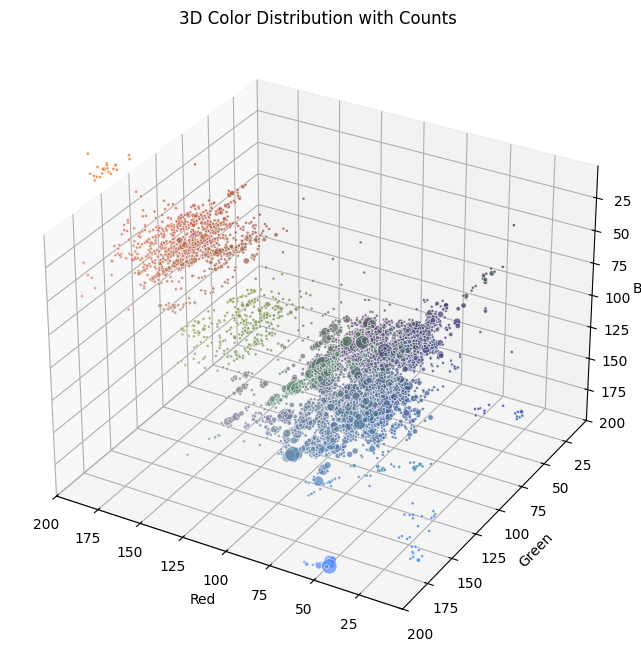

In [23]:
def plot_color_counts_3d(color_counter):
    # Extract RGB components and counts
    r_values = [color[0] for color in color_counter.keys()]
    g_values = [color[1] for color in color_counter.keys()]
    b_values = [color[2] for color in color_counter.keys()]
    counts = list(color_counter.values())

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(200)
    ax.set_ylim(200)
    ax.set_zlim(200)
    

    # Scatter plot with colors and sizes
    scatter = ax.scatter(r_values, g_values, b_values, c=[(r/255, g/255, b/255) for r, g, b in color_counter.keys()],
                         s=[count * 5 for count in counts], alpha=0.7, edgecolor='w', linewidth=0.5)

    # Set axis labels and title
    ax.set_xlabel("Red")
    ax.set_ylabel("Green")
    ax.set_zlabel("Blue")
    ax.set_title("3D Color Distribution with Counts")

    plt.show()

# plot_color_counts_3d(counts)
plot_color_counts_3d(counts)

In [46]:
def show_images_with_colors(folder_path, num_examples=5):
    image_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg'):
                image_files.append(os.path.join(root, file))

    
     # Randomly select a subset of images to display
    selected_images = random.sample(image_files, min(num_examples, len(image_files)))

    # Set up the plot grid
    fig, axes = plt.subplots(len(selected_images), 2, figsize=(8, 4 * num_examples))
    
    for i, filename in enumerate(selected_images):
        image = Image.open(filename)
        
        # Get the dominant color of the image
        dominant_color = extract_dominant_color(filename)
        
        # Display the image
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image: {filename}")
        
        # Display the color patch
        axes[i, 1].imshow([[dominant_color]], aspect="auto")
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Dominant Color: {dominant_color}")
    
    plt.tight_layout()
    plt.show()

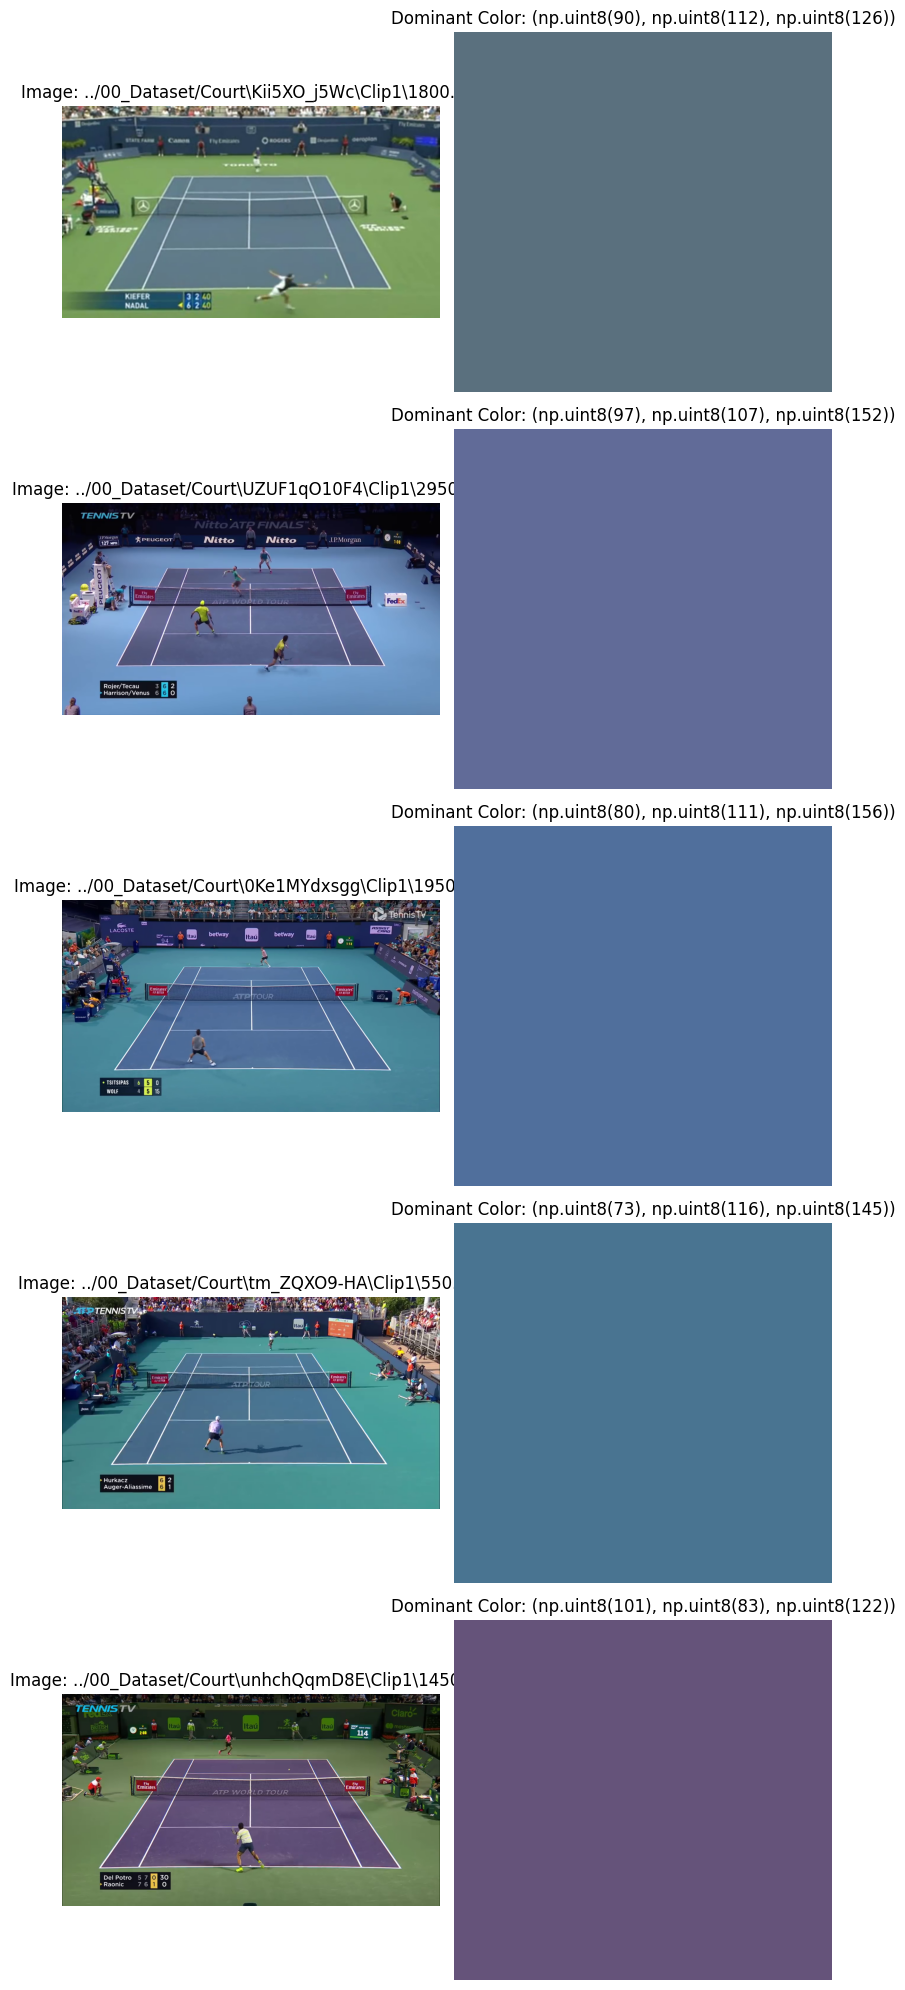

In [47]:
folder_path = "../00_Dataset/Court"
show_images_with_colors(folder_path)

## Clustering for court color detection

In [50]:
# create dataset from counter
def create_dataset(color_counter):
    # Create a DataFrame from the color counter
    df = pd.DataFrame(columns=["red", "green", "blue"])

    # loop over counter
    for color, count in color_counter.items():
        # append color count times
        for _ in range(count):
            # add row to dataframe using concat
            df = pd.concat([df, pd.DataFrame({"red": [color[0]], "green": [color[1]], "blue": [color[2]]})], ignore_index=True)
    
    return df

color_df = create_dataset(counts)

In [51]:
k= 4
# Train a KMeans model
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(color_df)
cluster_centers = kmeans.cluster_centers_

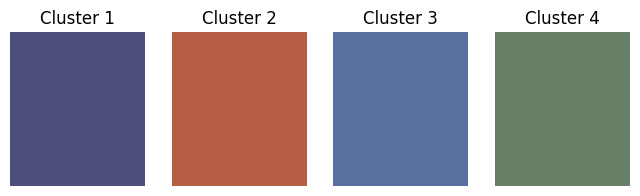

In [52]:
def show_color_centers(cluster_centers):
    # Create a plot for the color centers
    plt.figure(figsize=(8, 2))
    
    # Plot each cluster center as a color patch
    for i, color in enumerate(cluster_centers):
        plt.subplot(1, len(cluster_centers), i + 1)
        plt.imshow([[color / 255]], aspect='auto')  # Divide by 255 to normalize RGB values to [0, 1]
        plt.axis('off')
        plt.title(f'Cluster {i + 1}')
    
    plt.show()

# Show the color centers
show_color_centers(cluster_centers)

In [68]:
# get all file names from foler
def get_file_names(folder_path):
    image_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg'):
                image_files.append(os.path.join(root, file))
    return image_files


def show_images_with_cluster_color(folder_path, kmeans, cluster_centers):
    # Filter for only PNG images in the directory
    image_files = get_file_names(folder_path)

    print(f"Found {len(image_files)} images in the folder")
    
    selected_images = []

     # select one image for each cluster center
    for i in range(k):
       while True:
         # get a random image
            image_name = random.choice(image_files)
            # get the label
            dominant_color, label = classify_court(image_name, kmeans, cluster_centers)
            # check if the label is the same as the cluster center
            if label == i:
                selected_images.append(image_name)
                break

    # Set up the plot grid
    fig, axes = plt.subplots(len(selected_images), 1, figsize=(8, 4 * len(selected_images)))
    
    for i, filename in enumerate(selected_images):
        # Open the image
        image = Image.open(filename)
        
        # Classify the court and get the dominant cluster color
        court_cluster, label = classify_court(filename, kmeans, cluster_centers)
        
        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Image: {filename} (Cluster: {label})")

        margin = 0.05  # Margin as a fraction of axis size
        patch_size = 0.15  # Size of the color patch as a fraction of axis size
        
        color_patch = Rectangle(
            (1 - patch_size - margin, 1 - patch_size - margin),  # Position with margin
            patch_size, patch_size,  # Size of the rectangle
            transform=axes[i].transAxes,
            facecolor=(court_cluster[0]/255, court_cluster[1]/255, court_cluster[2]/255),  # Normalize RGB
            edgecolor="black", linewidth=2  # Black border with line width
        )
        axes[i].add_patch(color_patch)

    plt.tight_layout()
    plt.show()

Found 8841 images in the folder


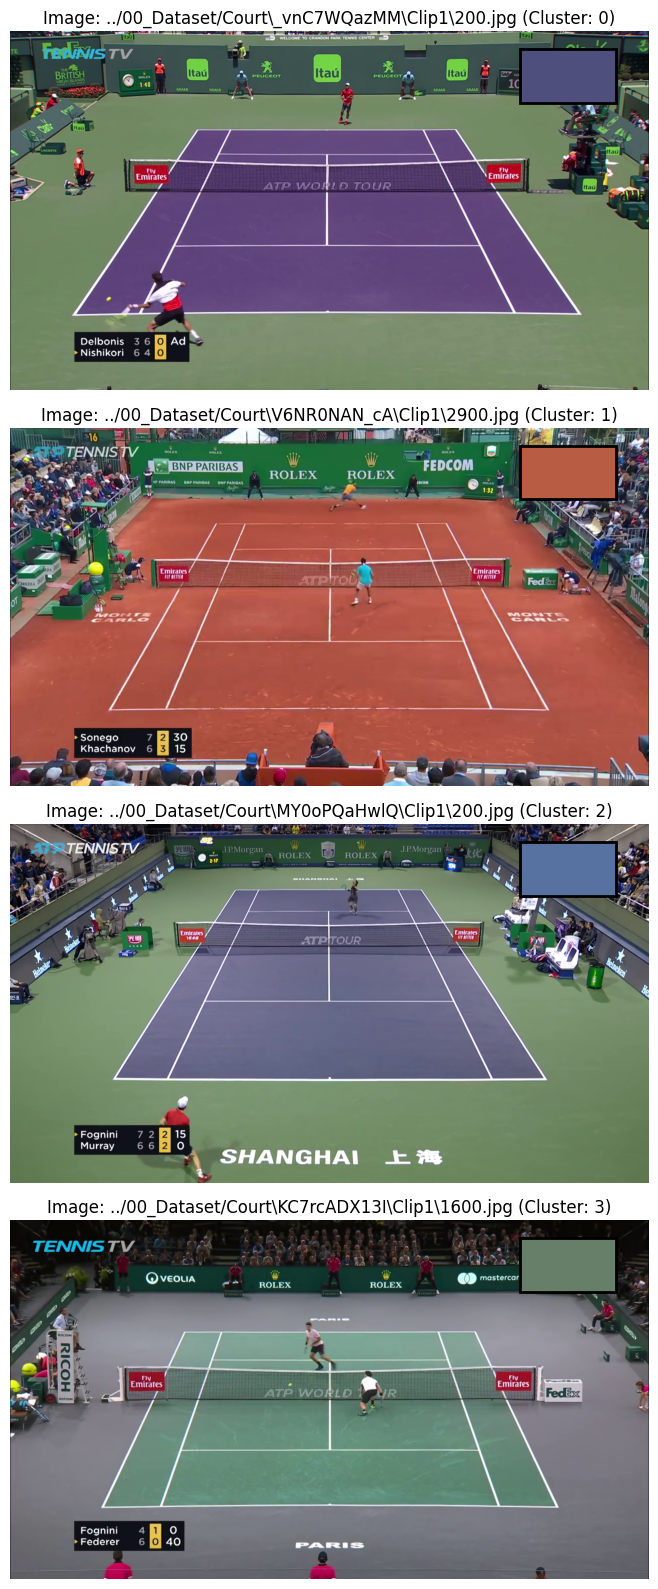

In [69]:
show_images_with_cluster_color("../00_Dataset/Court", kmeans, cluster_centers)

## Keypoint distribution visualization

In [70]:
set_plot_style_default()

[[378, 220], [442, 220], [828, 220], [892, 220], [132, 587], [258, 586], [1011, 586], [1136, 585], [418, 268], [852, 268], [326, 451], [943, 450], [635, 268], [635, 450]]


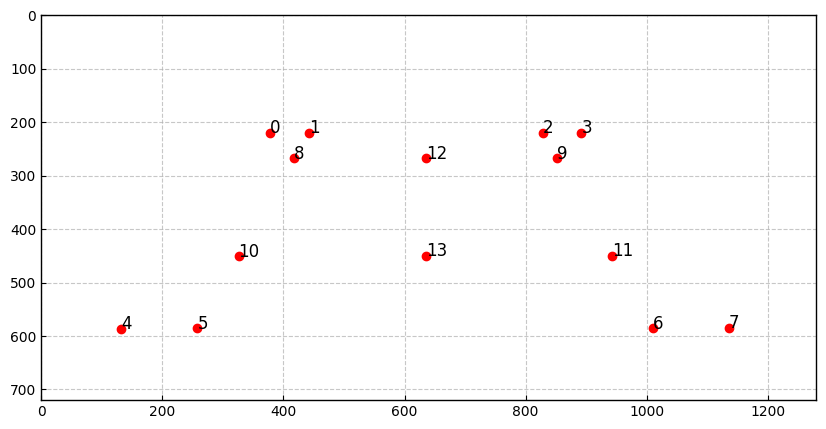

In [71]:
# plot court with keypoints
def plot_court(data, subset, video, clip, frame):
    keys = list(data['subsets'][subset]['videos'][video]['clips'][clip]['frames_with_objects'].keys())
    key = frame if frame in data['subsets'][subset]['videos'][video]['clips'][clip]['frames_with_objects'].keys() else keys[0]

    kps_dict = data['subsets'][subset]['videos'][video]['clips'][clip]['frames_with_objects'][key]['keypoints'][0]['points']
    # get values in list
    kps = [kp for kp in kps_dict.values()]
    print(kps)
    # plot the keypoints
    plt.figure(figsize=(10, 5))
    plt.scatter([kp[0] for kp in kps], [kp[1] for kp in kps], color='red')
    # add text for keypoints with number in the list
    for i, kp in enumerate(kps):
        plt.text(kp[0], kp[1], str(i), fontsize=12, color='black')
    # set axis lim to fit 720p
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.gca().invert_yaxis()
    plt.show()

# plot the first image
plot_court(data,2,0,0,0)

In [72]:
#iterate over combined and get tzhe first keypoint
def get_x_keypoint(subset, select=[]):
    keypoints = {}
    for video in data['subsets'][subset]['videos']:
        for clip in video['clips']:
            for frame_number, frame in clip['frames_with_objects'].items():
                kps = frame['keypoints'][0]['points']
                # iterate over dictionary
                for key, kp in kps.items():
                    if len(select) == 0 or key in select:
                        if key not in keypoints:
                            keypoints[key] = []
                        keypoints[key].append(kp)
                break

    return keypoints

# get all keypoints
select = ['top_left_corner', 'top_right_corner', 'bottom_left_corner', 'bottom_right_corner']
keypoints = get_x_keypoint(2, select)

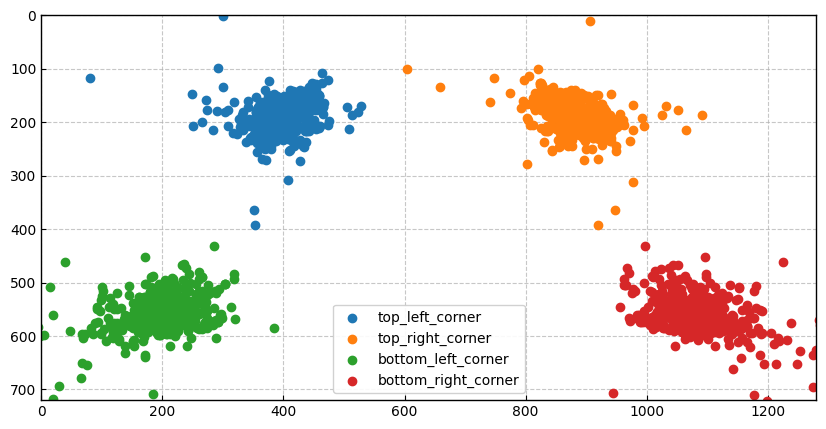

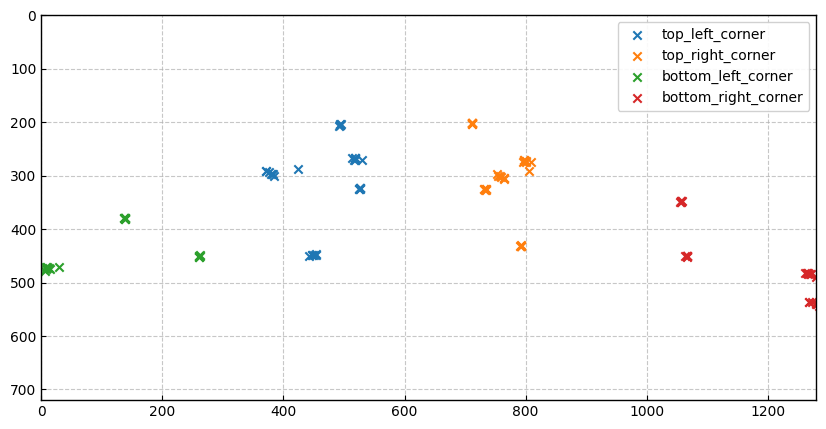

In [73]:
def plot_keypoints(subset, marker_type='o'):
    keypoints = get_x_keypoint(subset, select)
    resolution = data['subsets'][subset]['resolution']

    # Create a plot
    plt.figure(figsize=(10, 5))
    
    # Plot the keypoints
    for key, kp in keypoints.items():
        plt.scatter([p[0] for p in kp], [p[1] for p in kp], label=key, marker=marker_type)
    
    # Set the axis limits
    plt.xlim(0, resolution[0])
    plt.ylim(0, resolution[1])
    
    # Invert the y-axis to match the image
    plt.gca().invert_yaxis()
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()

plot_keypoints(2)
plot_keypoints(0, marker_type='x')

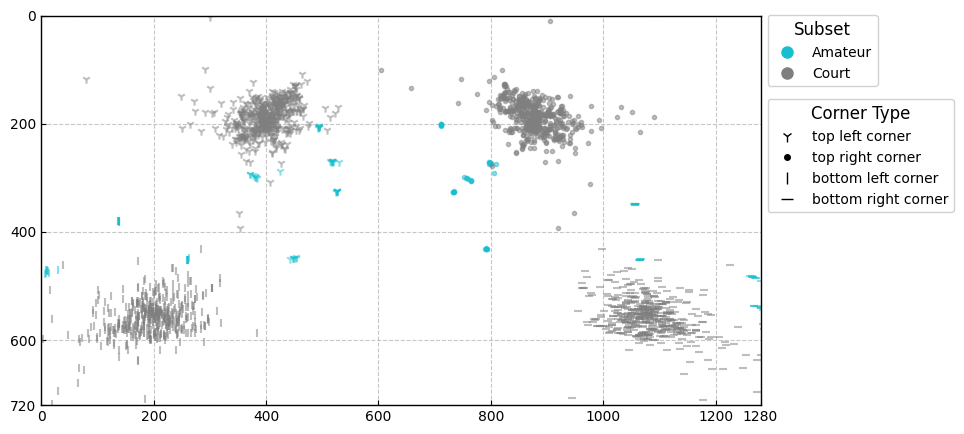

In [75]:
def plot_both_subsets():
    subsetData = []
    
    # select random colors from d3 colors
    colors = random.sample(d3_colors, 2)
    colors = [d3_colors[9], d3_colors[7]]
    markers = ['1', '.', '|', '_']  # Different markers for each keypoint type (corner types)

    # Assuming get_x_keypoint and data are defined
    for subset in [0, 2]:
        keypoints = get_x_keypoint(subset, select)

        subsetData.append(keypoints)

    # Create a plot
    plt.figure(figsize=(9.8, 4.5))
    for i, subset in enumerate(subsetData):
        for j, (key, kp) in enumerate(subset.items()):
            color = colors[i]  # Use different color for each subset
            marker = markers[j % len(markers)]  # Use different marker for each keypoint type

            # Plot each subset with its unique color and each corner type with a unique marker
            plt.scatter([p[0] for p in kp], [p[1] for p in kp], color=color, marker=marker, alpha=0.5)

    # Set the axis limits
    plt.xlim(0, 1280)
    plt.ylim(0, 720)

    # Set custom ticks to ensure the max values are included
    plt.xticks([0, 200, 400, 600, 800,1000, 1200, 1280])
    plt.yticks([0, 200, 400, 600, 720])

    # Invert the y-axis to match the image
    plt.gca().invert_yaxis()
    
    # Custom legend for markers (corner types)
    labels = ['top left corner', 'top right corner', 'bottom left corner', 'bottom right corner']
    marker_legend = [mlines.Line2D([], [], color='black', marker=marker, linestyle='None', markersize=8, label=label)
                     for marker, label in zip(markers, labels)]

    # Custom legend for colors (subsets)
    labels_color = ['Amateur', 'Court']
    color_legend = [mlines.Line2D([], [], color=color, linestyle='None', marker='o', markersize=8, label=label)
                    for color, label in zip(colors, labels_color)]

    # Display the marker legend on top for corner types
    color_legend_handle = plt.legend(handles=color_legend, title="Subset", loc="center left", bbox_to_anchor=(1, 0.91))

    # Display the color legend below the marker legend for subsets
    plt.gca().add_artist(color_legend_handle)  # Ensure the marker legend remains on the plot
    plt.legend(handles=marker_legend, title="Corner Type", loc="center left", bbox_to_anchor=(1, 0.64))

    # Adjust the plot layout to fit legends
    plt.tight_layout()
    
    # Show the plot
    plt.show()

plot_both_subsets()